<a href="https://colab.research.google.com/github/gauravreddy08/food-vision/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dish Decoder** 🍔👁️

This is an **end-to-end CNN Image Classification Model** which decodes and identifies the food in your image.

I worked out with a pretrained Image Classification Model that comes with Keras and then retrained it on the infamous **Food101 Dataset**.


**Fun Fact :**

The Model actually beats the DeepFood Paper's model which also trained on the same dataset.

The Accuracy of [**DeepFood**](https://arxiv.org/abs/1606.05675) was **77.4%** and our model's is **85%**. Difference of **8%** ain't much but the interesting thing is, DeepFood's model took 2-3 days to train while our's was around 60min.

> **Dataset :** `Food101`

> **Model :** `EfficientNetB1`





## **Setting up the Workspace**

* Checking the GPU
* Mounting Google Drive
* Importing Tensorflow
* Importing other required Packages


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fbdc23b7-6c7d-0a2e-1644-e2cedbdbddd1)



### **Mounting Google Drive**




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing Tensorflow**

At the time of writing, `tesnorflow 2.5.0` has a bug with EfficientNet Models. [Click Here](https://github.com/tensorflow/tensorflow/issues/49725) to get more info about the bug. Hopefully tensorflow fixes it soon.

So the below code is used to downgrade the version to `tensorflow 2.4.1`, it will take a moment to uninstall the previous version and install our required version.

> You need to restart the **Runtime** after required version of tensorflow is installed.

**Note :** Restarting runtime won't assign you a new GPU.

In [1]:
#!pip install tensorflow==2.4.1
import tensorflow as tf
print(tf.__version__)

2.14.0


### **Importing other required Packages**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

#### **Importing `helper_fuctions`**

The `helper_functions.py` is a python script created by me. Which has some important functions I use frequently while building Deep Learning Models.

In [5]:
!wget https://raw.githubusercontent.com/sg-sparsh-goyal/extras/main/helper_function.py

--2023-10-25 15:20:43--  https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-25 15:20:43 (89.4 MB/s) - ‘helper_function.py’ saved [10246/10246]



In [6]:
from helper_function import plot_loss_curves, load_and_prep_image

## **Getting the Data Ready**

The Dataset used is **Food101**, which is available on both Kaggle and Tensorflow.

In the below cells we will be importing Datasets from `Tensorflow Datasets` Module.


In [7]:
# Prints list of Datasets avaible in Tensorflow Datasets Module

dataset_list = tfds.list_builders()
dataset_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

### **Importing Food101 Dataset**

**Disclaimer :**
The below cell will take time to run, as it will be downloading
**4.65GB data** from **Tensorflow Datasets Module**.

So do check if you have enough **Disk Space** and **Bandwidth Cap** to run the below cell.

In [8]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete74NB07/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete74NB07/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## **Becoming One with the Data**

One of the most important steps in building any ML or DL Model is to **become one with the data**.

Once you get the gist of what type of data your dealing with and how it is structured, everything else will fall in place.

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
train_one_sample = train_data.take(1)

In [12]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image Datatype : {image.dtype}
  Class : {class_names[label.numpy()]}
  """)


  Image Shape : (512, 512, 3)
  Image Datatype : <dtype: 'uint8'>
  Class : huevos_rancheros
  


In [14]:
image[:2]

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]]], dtype=uint8)>

In [15]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

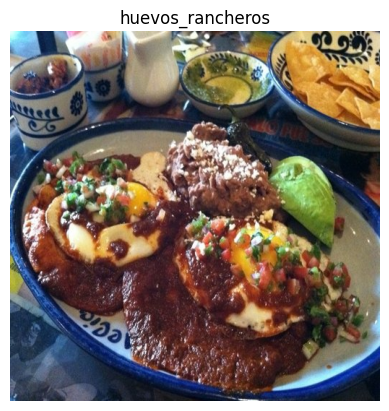

In [16]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **Preprocessing the Data**

Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

In [17]:
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [18]:
# Trying the preprocess function on a single image

preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
array([[[230.6  , 253.6  , 251.   ],
        [223.   , 255.   , 252.2  ],
        [207.1  , 255.   , 250.4  ],
        ...,
        [140.6  , 129.5  , 121.25 ],
        [121.1  , 115.25 , 116.94 ],
        [ 83.94 ,  83.06 ,  89.6  ]],

       [[221.5  , 254.4  , 253.4  ],
        [214.5  , 255.   , 253.9  ],
        [198.4  , 254.6  , 252.   ],
        ...,
        [208.6  , 195.9  , 173.4  ],
        [197.   , 190.1  , 174.9  ],
        [175.5  , 171.6  , 161.2  ]],

       [[204.2  , 253.4  , 249.6  ],
        [198.8  , 254.6  , 251.2  ],
        [185.   , 251.8  , 252.2  ],
        ...,
        [222.5  , 207.5  , 169.4  ],
        [216.5  , 205.   , 172.   ],
        [215.5  , 207.9  , 177.6  ]],

       ...,

       [[ 47.12 ,  81.06 , 121.2  ],
        [ 30.4  ,  63.62 , 101.3  ],
        [127.4  , 158.9  , 193.   ],
        ...,
        [  3.953,  11.95 ,  23.38 ],
        [  2.27 ,  10.33 ,  21.22 ],
        [  6.863,  16.0

In [19]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [20]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [21]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## **Building the Model : EfficientNetB1**


### **Getting the Callbacks ready**
As we are dealing with a complex Neural Network (EfficientNetB1) its a good practice to have few call backs set up. Few callbacks I will be using throughtout this Notebook are :
 * **TensorBoard Callback :** TensorBoard provides the visualization and tooling needed for machine learning experimentation

 * **EarlyStoppingCallback :** Used to stop training when a monitored metric has stopped improving.

 * **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.


 We already have **TensorBoardCallBack** function setup in out helper function, all we have to do is get other callbacks ready.

In [22]:
from helper_function import create_tensorboard_callback

In [23]:
# EarlyStopping Callback

early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

In [24]:
# ReduceLROnPlateau Callback

lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-7,
                                                patience=0,
                                                verbose=1)



### **Mixed Precision Training**
Mixed precision is used for training neural networks, reducing training time and memory requirements without affecting the model performance.

More Specifically, in **Mixed Precision** we will setting global dtype as `mixed_float16`. Because modern accelerators can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.


In [25]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">



### **Building the Model**

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Input and Data Augmentation
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)

x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)

x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["accuracy"])

27018416/27018416 [==============================] - 3s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, None, None, 1280   6575239   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0     

In [29]:
history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                               early_stopping_callback,
                               lower_lr])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20231025-153744
Epoch 1/50
2368/2368 [==============================] - 651s 238ms/step - loss: 1.7453 - accuracy: 0.5585 - val_loss: 1.1990 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 2/50
2368/2368 [==============================] - 561s 235ms/step - loss: 1.1474 - accuracy: 0.6948 - val_loss: 0.9650 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 0.9262 - accuracy: 0.7477
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 565s 237ms/step - loss: 0.9262 - accuracy: 0.7477 - val_loss: 1.0586 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 4/50
2368/2368 [==============================] - 562s 235ms/step - loss: 0.4674 - accuracy: 0.8687 - val_loss: 0.6092 - val_accuracy: 0.8379 - lr: 2.0000e-04
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.9140
Epoch 5: Re

In [30]:
# Saving the model
model.save("/content/drive/My Drive/FinalModel.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Saving the model
model.save("FoodVision.hdf5")

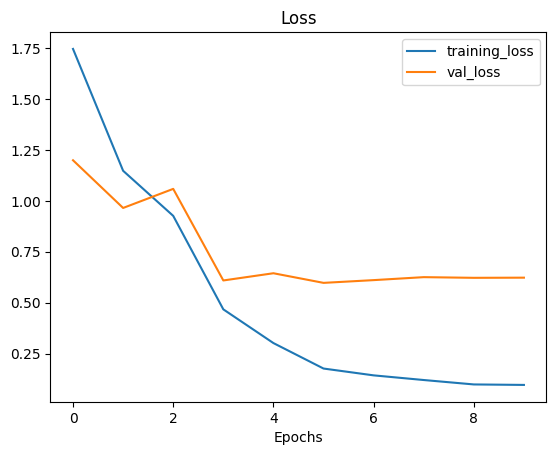

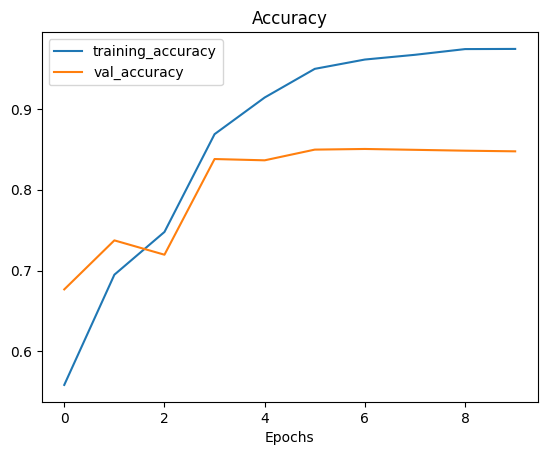

In [32]:
plot_loss_curves(history)

In [33]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 0.6330 - accuracy: 0.8449


[0.6330106854438782, 0.8449109196662903]

## **Evaluating our Model**

In [34]:
%load_ext tensorboard
%tensorboard --logdir training-logs

<IPython.core.display.Javascript object>

In [35]:
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 [==============================] - 67s 77ms/step


(25250, (25250, 101))

In [36]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [37]:
# Getting true labels for the test_data

y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [38]:
# Predicted Labels vs. True Labels
pred_classes==y_labels

array([ True,  True,  True, ..., False,  True, False])

### **Sklearn's Accuracy Score**

In [39]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.8449108910891089

### **Confusion Matrix**
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

In [44]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (100, 100));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Purples');

### **Model's Class-wise Accuracy Score**

In [42]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [43]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.6359832635983264,
 'baby_back_ribs': 0.844,
 'baklava': 0.9024390243902439,
 'beef_carpaccio': 0.8977955911823646,
 'beef_tartare': 0.8016032064128257,
 'beet_salad': 0.7599164926931106,
 'beignets': 0.8627450980392156,
 'bibimbap': 0.9477911646586344,
 'bread_pudding': 0.6946564885496183,
 'breakfast_burrito': 0.800796812749004,
 'bruschetta': 0.7861507128309573,
 'caesar_salad': 0.8781431334622823,
 'cannoli': 0.9142857142857143,
 'caprese_salad': 0.8372093023255813,
 'carrot_cake': 0.8221343873517787,
 'ceviche': 0.722689075630252,
 'cheesecake': 0.7402862985685071,
 'cheese_plate': 0.8806584362139918,
 'chicken_curry': 0.8049281314168379,
 'chicken_quesadilla': 0.8438133874239351,
 'chicken_wings': 0.884,
 'chocolate_cake': 0.7648261758691207,
 'chocolate_mousse': 0.6666666666666666,
 'churros': 0.8995983935742972,
 'clam_chowder': 0.9190283400809717,
 'club_sandwich': 0.8824742268041236,
 'crab_cakes': 0.7741935483870968,
 'creme_brulee': 0.9033530571992111,
 'croq

In [45]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [46]:
report_df = report_df.sort_values("f1-scores", ascending=True)

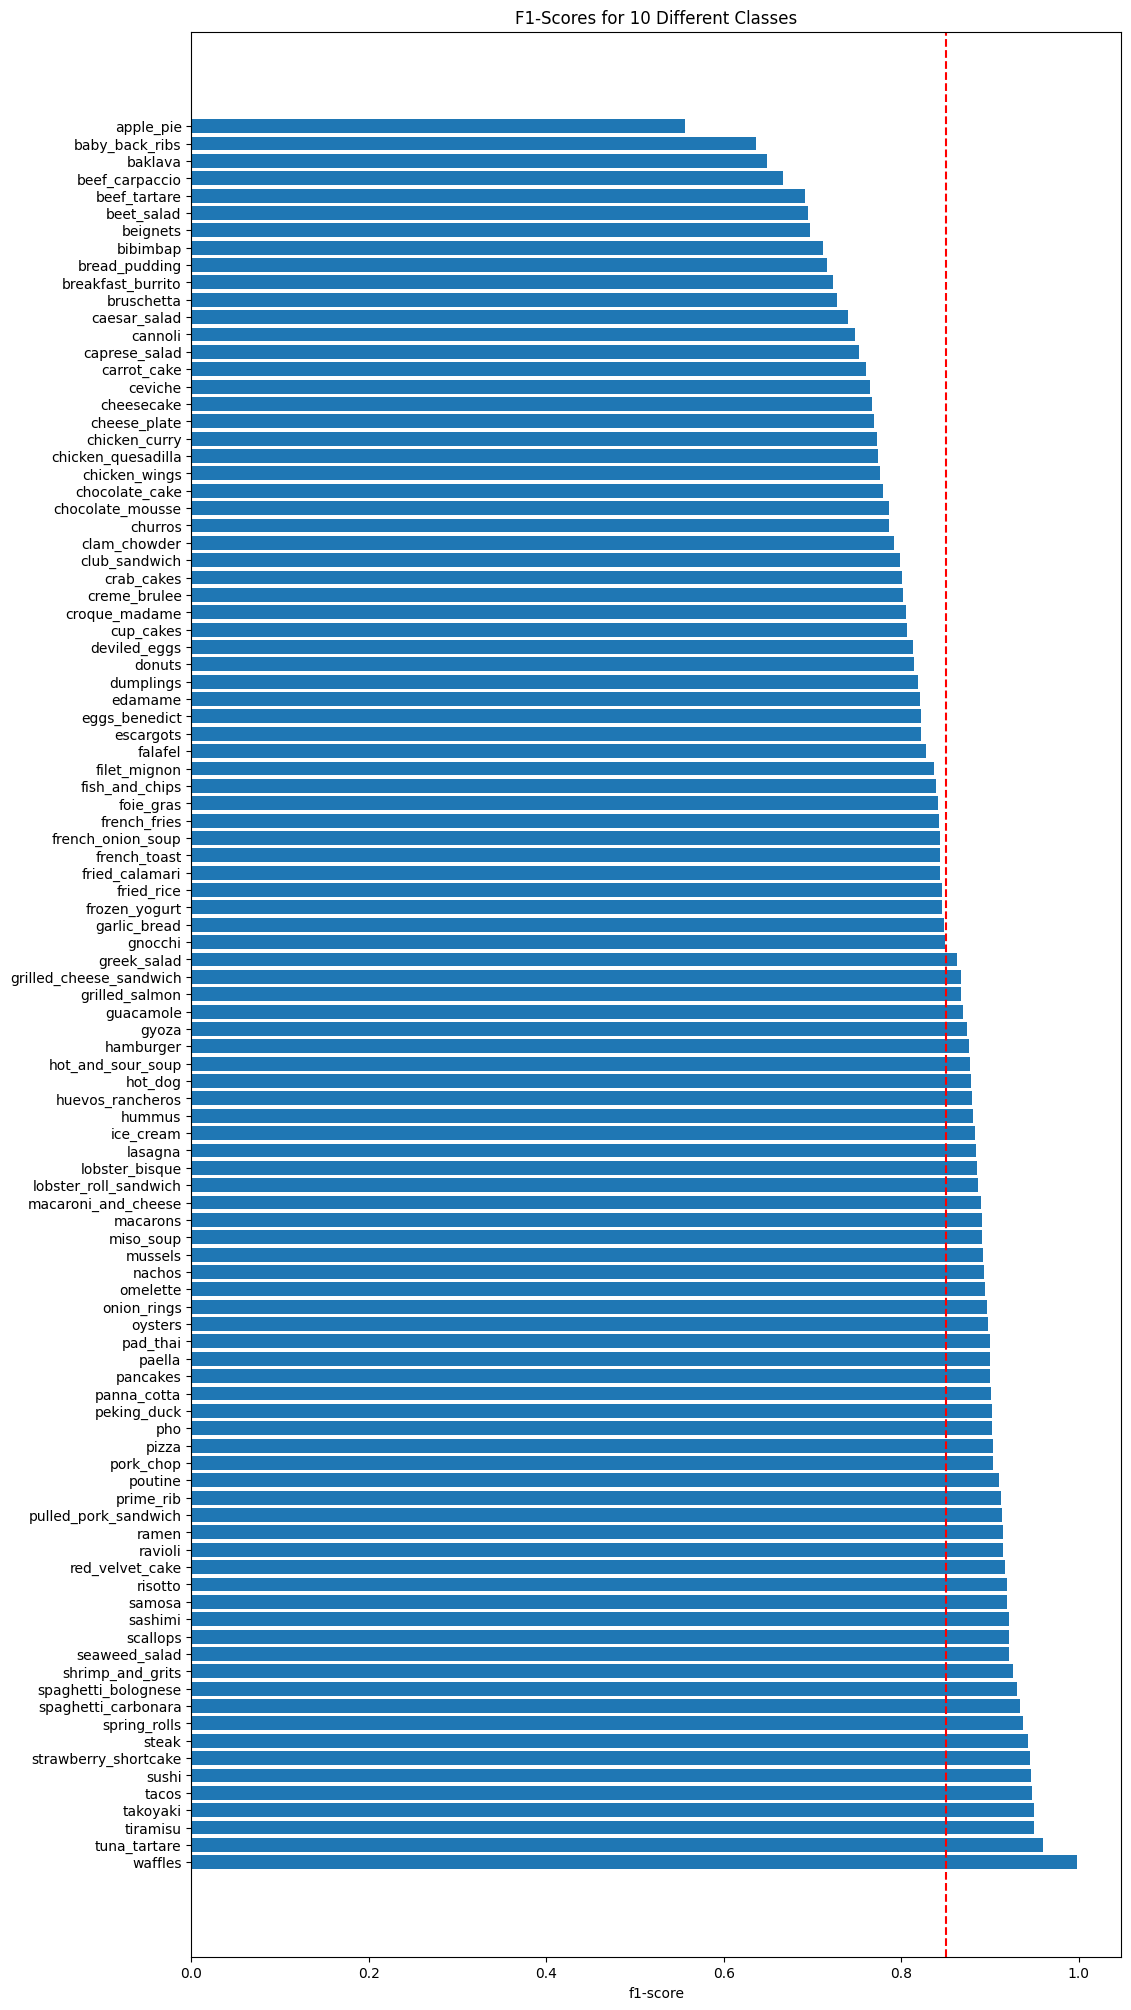

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for Different Classes")
ax.invert_yaxis(); # reverse the order

### **Predicting on our own Custom images**

Once we have our model ready, its cruicial to evaluate it on our custom data : the data our model has never seen.

Training and evaluating a model on train and test data is cool, but making predictions on our own realtime images is another level.



In [53]:
import os

directory_path = "/content/drive/MyDrive/FoodVisionModels/Custom Images"
os.makedirs(directory_path, exist_ok=True)

custom_food_images = [directory_path + img_path for img_path in os.listdir(directory_path)]
custom_food_images

['/content/drive/MyDrive/FoodVisionModels/Custom Imagesistockphoto-945057664-170667a.jpg']

In [69]:
import os
import matplotlib.pyplot as plt

def pred_plot_custom(folder_path):
    custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, img_path))]

    for img in custom_food_images:
        img = load_and_prep_image(img, scale=False)
        pred_prob = model.predict(tf.expand_dims(img, axis=0))
        pred_class = class_names[pred_prob.argmax()]
        top_5_i = (pred_prob.argsort())[0][-5:][::-1]
        values = pred_prob[0][top_5_i]
        labels = []

        for x in range(5):
            labels.append(class_names[top_5_i[x]])

        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        # Plotting Image
        ax[0].imshow(img/255.)
        ax[0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
        ax[0].axis('off')

        # Plotting Models Top 5 Predictions
        ax[1].bar(labels, values, color='orange')
        ax[1].set_title('Top 5 Predictions')

        plt.show()


1/1 [==============================] - 0s 28ms/step


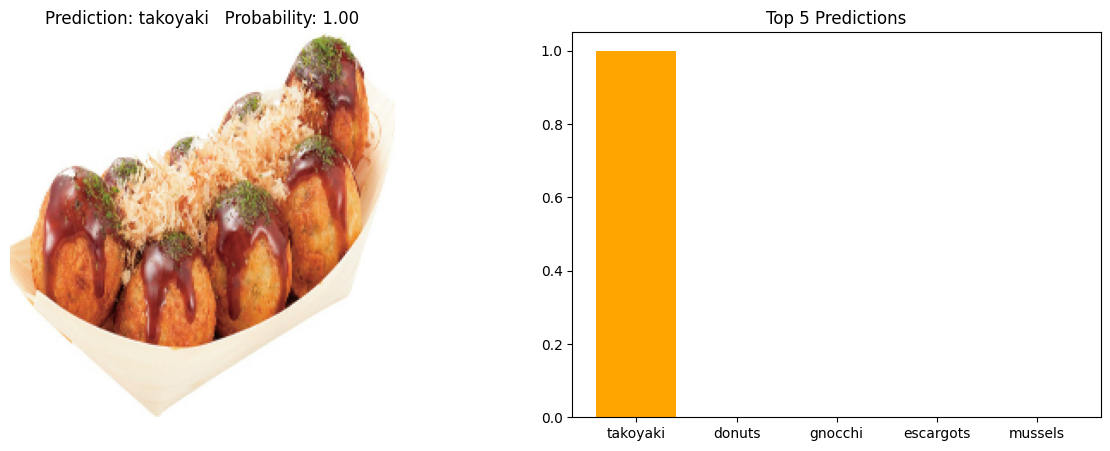

1/1 [==============================] - 0s 31ms/step


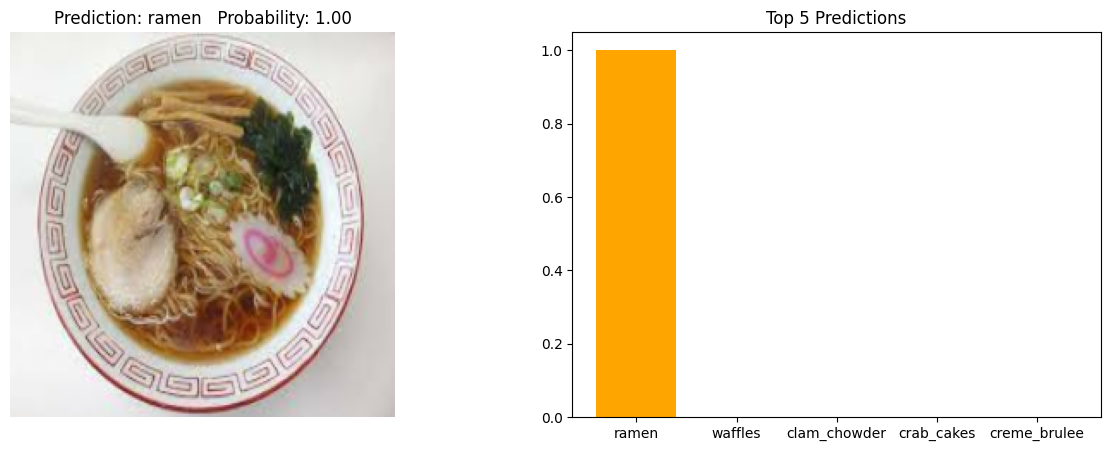

1/1 [==============================] - 0s 36ms/step


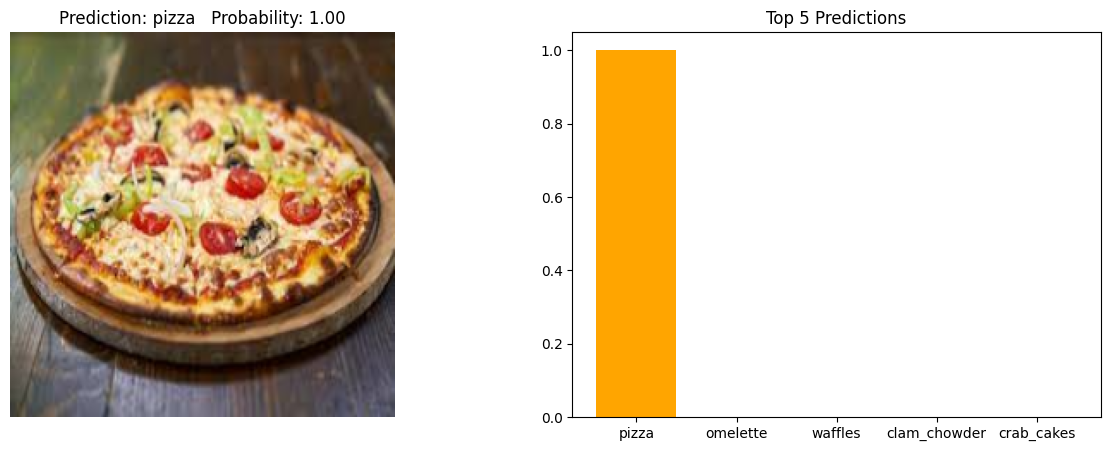

In [71]:
pred_plot_custom("/content/drive/MyDrive/FoodVisionModels/Custom Images/")